# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import os
import time
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
from maddpg_agent import Agent

In [8]:
seed = 0

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -7.0517621  -1.5        -0.          0.
 -7.11741829  5.91759634 -0.          0.        ]


In [10]:
#Create Agent
#agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=seed)
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=seed)

In [11]:
def maddpg(n_episodes=5000, max_t=1200, print_interval=100):
    scores_deque = deque(maxlen=print_interval)
    scores = []
    mean_scores = []   
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action1 = agent.act(state[0])
            action2 = agent.act(state[1])
            action = np.concatenate((action1, action2), axis=0)
            action = np.clip(action, -1, 1)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break
        scores_deque.append(np.max(score))
        scores.append(np.max(score))    
        mean_scores.append(np.mean(scores_deque))  # save running mean
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_interval == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 0.7:
            torch.save(agent.actor_local.state_dict(), 'solved_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'solved_checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode-100, np.mean(scores_deque)))
            break

    np.save('scores.npy', scores)
    return scores, mean_scores

In [12]:
%%time 
scores, mean_scores = maddpg(n_episodes=5000, max_t=1200, print_interval=100)

Episode 100	Average Score: 0.0000
Episode 200	Average Score: 0.0098
Episode 300	Average Score: 0.0086
Episode 400	Average Score: 0.0000
Episode 500	Average Score: 0.0000
Episode 600	Average Score: 0.0284
Episode 700	Average Score: 0.0030
Episode 800	Average Score: 0.0009
Episode 900	Average Score: 0.0584
Episode 1000	Average Score: 0.1753
Episode 1099	Average Score: 0.7002
Environment solved in 999 episodes!	Average Score: 0.7002
CPU times: user 11min 24s, sys: 25.9 s, total: 11min 50s
Wall time: 12min 44s


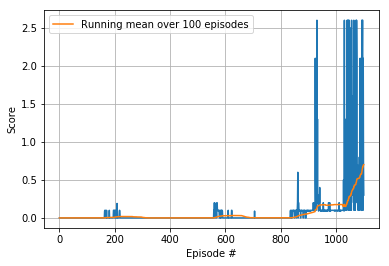

In [13]:
plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(mean_scores)+1), mean_scores, label='Running mean over 100 episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [14]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1)
#Load saved neural networks's weights
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))                                        # play game for 5 episodes
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    action1 = agent.act(states[0])
    action2 = agent.act(states[1])
    action = np.concatenate((action1, action2), axis=0)
    action = np.clip(action, -1, 1)             # all actions between -1 and 1
    env_info = env.step(action)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09500000160187483


In [15]:
env.close()

## Report 

#### Learning Algorithm 
Deep Deterministic Policy Gradient or commonly known as DDPG is basically an off-policy method that learns a Q-function and a policy to iterate over actions. It employs the use of off-policy data and the Bellman equation to learn the Q function which is in turn used to derive and learn the policy.(Referred from [here](https://medium.com/analytics-vidhya/demystifying-deep-deterministic-policy-gradient-ddpg-uding-chainerrl-and-openai-baselines-a087a11630cc#:~:text=Deep%20Deterministic%20Policy%20Gradient%20or,derive%20and%20learn%20the%20policy.)

#### Model architectures

The basic algorithm s an actor-critici method. Policy-based methods using Monte Carlo estimates have high variance problems. TD estimates used in value-based methods have low bias and low variance. Actor critic methods combine these two ideas, the neural network in which the actor renews his or her policies and another neural network in evaluating the policies used to train the actor.

The actor network consists of three fully connected layers with batch normalization applied to the first layer. The network map specifies the behavior. Use the ReLU as an activation function except the last layer with a tanh.

The Critic Network also consists of three fully connected layers with batch normalization applied to the first layer. Map a network map (state, action) pair to the Q-value. The ReLU is used as an activation feature for the first two layers, and there is no activation function for the last layer.

#### Model Parameters

- `state size` = 24
- `action size` = 2
- `number of agents` = 2
- `max time for episode` = 1200s

following parameters implemented from this [repository](https://github.com/ishgirwan/udacity_drlnd/tree/master/Collaboration%20and%20Competition)
- `fc1_unit` = 400
- `fc2_unit` = 300

- `BUFFER_SIZE` = int(1e6) # replay buffer size
- `BATCH_SIZE` = 128       # minibatch size
- `GAMMA` = 0.99           # discount factor
- `TAU` = 1e-3             # for soft update of target parameters
- `LR_ACTOR` = 1e-3        # learning rate of the actor
- `LR_CRITIC` = 1e-3       # learning rate of the critic
- `WEIGHT_DECAY` = 0       # L2 weight decay

- `LEARN_EVERY` = 20       # learning timestep interval
- `LEARN_NUM` = 10            # number of learning passes
- `GRAD_CLIPPING` = 1.0         # gradient clipping 

#### Idea to improve the performance 
- DDPG can be improved through priority experience regeneration.
- Fine adjustment of the hperparameter can lead to better results and faster training times.
- Multi-agent actor critics in mixed, collaborative competitive environments
- The Q-prop algorithm combined with off-polycy learning and on-polycy learning can be good to try.
- General optimization techniques such as periodic learning speed and warm restart may also be useful.